Reference paper (not my work) - https://arxiv.org/abs/1901.11103
RNN to learn the potential to density mapping

In [777]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [778]:
potentials_dict = np.load('./Potentials.npz')
densities_dict = np.load('./Densities.npz')

In [779]:
potentials = potentials_dict['arr_0']
densities = densities_dict['arr_0']

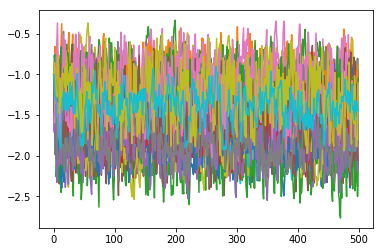

In [780]:
for i in range(len(potentials)):
    plt.plot(potentials[i])

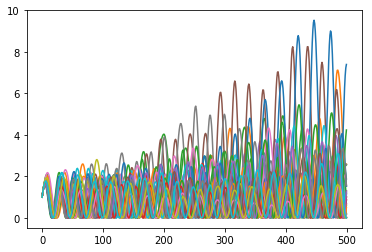

In [781]:
for i in range(len(densities)):
    plt.plot(densities[i])

In [782]:
class IntroRNN(nn.Module):
    
    def __init__(self, n_steps, order, hidden_dim):
        super(IntroRNN, self).__init__()
        self.nw = order
        self.d = hidden_dim
        W = torch.zeros(self.nw, self.d, self.d)
        W[0] = torch.ones(self.d, self.d) + (1/self.d) * 0.01 * torch.randn(self.d, self.d)
        for i in range(1, self.nw):
            W[i] = (1/self.d) * 0.01 * torch.randn(self.d, self.d)
        self.W = nn.Parameter(W.clone())
        self.register_buffer('h', torch.ones(self.d))
        p = torch.zeros(self.d)
        p[0] = 1
        self.p = nn.Parameter(p.clone())
        self.T = n_steps

    def forward(self, x):
        assert x.shape == torch.Size([self.T, 1])
        x = torch.squeeze(x)
        out = torch.zeros(self.T)
        for i in range(self.T):
            coeffs = torch.stack([self.W[j]*(x[i]**j) for j in range(self.nw)])
            self.h = torch.mv(coeffs.sum(dim = 0), self.h)
            out[i] = torch.dot(self.p, self.h)
        return out
    
    def init_hidden(self):
        self.h = torch.ones(self.d).cuda()        

In [783]:
n_steps = 15
order = 4
hidden_dim = 4
rnn = IntroRNN(n_steps, order, hidden_dim)
list(rnn.parameters())

[Parameter containing:
 tensor([[[ 1.0008e+00,  1.0000e+00,  9.9621e-01,  9.9617e-01],
          [ 1.0048e+00,  1.0061e+00,  1.0028e+00,  9.9941e-01],
          [ 9.9995e-01,  1.0000e+00,  1.0027e+00,  1.0031e+00],
          [ 1.0025e+00,  1.0011e+00,  9.9613e-01,  9.9600e-01]],
 
         [[-1.2837e-03,  5.6038e-06, -3.5755e-03, -3.3541e-03],
          [-1.3422e-03,  2.9067e-03, -2.7109e-03, -3.7065e-03],
          [-1.5239e-03, -1.6174e-03, -1.3576e-03, -6.0475e-03],
          [ 2.2138e-03, -2.5067e-03, -1.5307e-03,  1.9304e-03]],
 
         [[-7.4476e-04, -1.7821e-03,  2.0375e-03,  3.2130e-03],
          [-3.1533e-03, -2.8626e-03,  1.9712e-03,  9.3089e-04],
          [-1.6133e-03, -1.1578e-03, -2.5643e-03,  1.7866e-03],
          [-1.5361e-04,  1.5642e-03,  1.5533e-04, -4.4577e-03]],
 
         [[-2.1663e-04,  1.5196e-03, -3.6077e-03, -1.0524e-03],
          [ 2.5912e-03,  1.9390e-03, -2.3554e-03,  1.3200e-04],
          [-1.4149e-04, -5.4802e-03,  4.6824e-04,  3.6980e-04],
        

In [784]:
x = torch.tensor(potentials[0][:n_steps], dtype = torch.float)
y = torch.tensor(densities[0][:n_steps], dtype = torch.float)

In [785]:
criterion = nn.MSELoss()
out = rnn(torch.unsqueeze(torch.as_tensor(x), dim = 1))
loss = criterion(out, y)
print(loss)
rnn.zero_grad()
loss.backward()
print(rnn.W.grad)
print(rnn.p.grad)

tensor(9.2290e+16, grad_fn=<MseLossBackward>)
tensor([[[ 2.0579e+17,  2.0439e+17,  2.0605e+17,  2.0403e+17],
         [ 1.6021e+17,  1.5923e+17,  1.6042e+17,  1.5893e+17],
         [ 1.6247e+17,  1.6147e+17,  1.6269e+17,  1.6117e+17],
         [ 1.6018e+17,  1.5920e+17,  1.6040e+17,  1.5890e+17]],

        [[-3.2983e+17, -3.2735e+17, -3.3024e+17, -3.2683e+17],
         [-2.5671e+17, -2.5491e+17, -2.5704e+17, -2.5447e+17],
         [-2.6061e+17, -2.5877e+17, -2.6095e+17, -2.5833e+17],
         [-2.5668e+17, -2.5487e+17, -2.5701e+17, -2.5444e+17]],

        [[ 5.4656e+17,  5.4215e+17,  5.4722e+17,  5.4136e+17],
         [ 4.2921e+17,  4.2588e+17,  4.2974e+17,  4.2523e+17],
         [ 4.3606e+17,  4.3268e+17,  4.3660e+17,  4.3201e+17],
         [ 4.2915e+17,  4.2583e+17,  4.2969e+17,  4.2517e+17]],

        [[-9.2936e+17, -9.2150e+17, -9.3046e+17, -9.2024e+17],
         [-7.4092e+17, -7.3478e+17, -7.4181e+17, -7.3375e+17],
         [-7.5313e+17, -7.4689e+17, -7.5404e+17, -7.4584e+17],
   

In [786]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [787]:
device

device(type='cuda', index=0)

In [788]:
n_seq = len(potentials)
seq_len = len(potentials[0])
n_train = 20

In [789]:
X_train = np.array([potentials[i][j*n_steps:(j + 1)*n_steps] for i in range(n_train) for j in range(1, seq_len//n_steps)])
X_train.shape

(640, 15)

In [790]:
y_train = np.array([densities[i][j*n_steps:(j + 1)*n_steps] for i in range(n_train) for j in range(1, seq_len//n_steps)])
y_train.shape

(640, 15)

In [791]:
# Xy = np.hstack((X_train, y_train))
# print(Xy.shape)
# np.random.shuffle(Xy)
# X_train = Xy[:, :X_train.shape[1]]
# y_train = Xy[:, X_train.shape[1]:]

In [792]:
X_train.shape

(640, 15)

In [793]:
y_train.shape

(640, 15)

In [794]:
model = IntroRNN(n_steps, order, hidden_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()
loss_vals = []

In [806]:
epochs = 15
avg_loss = 0
for e in range(epochs):
    avg_loss = 0
    for i in range(len(X_train)):
        data = torch.unsqueeze(torch.as_tensor(X_train[i], dtype = torch.float), dim = 1)
        data = data.to(device)
        target = torch.unsqueeze(torch.as_tensor(y_train[i], dtype = torch.float), dim = 1)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss_vals.append(loss.item())
        avg_loss += loss_vals[-1]
        loss.backward(retain_graph = True)
        optimizer.step()
#         if i % 2 == 0:
        model.init_hidden()
    avg_loss /= len(X_train)
    print('Epoch = {}, avg. loss = {:.3}'.format(e, avg_loss))

Epoch = 0, avg. loss = 7.04e+11
Epoch = 1, avg. loss = 5.03e+11
Epoch = 2, avg. loss = 3.58e+11
Epoch = 3, avg. loss = 2.55e+11
Epoch = 4, avg. loss = 1.81e+11
Epoch = 5, avg. loss = 1.28e+11
Epoch = 6, avg. loss = 9e+10
Epoch = 7, avg. loss = 6.3e+10
Epoch = 8, avg. loss = 4.39e+10
Epoch = 9, avg. loss = 3.03e+10
Epoch = 10, avg. loss = 2.07e+10
Epoch = 11, avg. loss = 1.4e+10
Epoch = 12, avg. loss = 9.25e+09
Epoch = 13, avg. loss = 5.98e+09
Epoch = 14, avg. loss = 3.74e+09


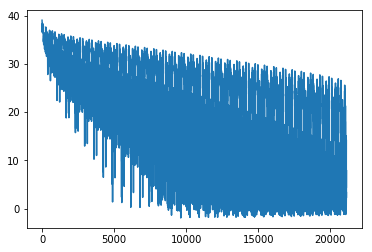

In [807]:
plt.plot(np.log(np.array(loss_vals)))

In [797]:
loss_vals[-10:-1]

[71205239390208.0,
 33900871024640.0,
 101121003618304.0,
 4910641315840.0,
 57940358725632.0,
 5433041354752.0,
 3177706160128.0,
 32803815161856.0,
 14188902612992.0]

In [798]:
out

tensor([2.4885e+00, 7.9581e+00, 2.3878e+01, 7.1679e+01, 2.0047e+02, 5.6828e+02,
        1.4771e+03, 4.4112e+03, 1.2733e+04, 3.9558e+04, 1.2525e+05, 3.7546e+05,
        1.0849e+06, 2.8559e+06, 7.4053e+06], grad_fn=<CopySlices>)

In [799]:
target

tensor([[1.2409],
        [1.7399],
        [2.2625],
        [2.7721],
        [3.2307],
        [3.6023],
        [3.8551],
        [3.9758],
        [3.9647],
        [3.8270],
        [3.5815],
        [3.2389],
        [2.8121],
        [2.3221],
        [1.7992]])

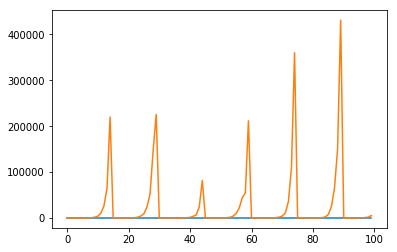

In [809]:
i = 2
y = densities[i]
X_test = [potentials[i][j*n_steps:(j + 1)*n_steps] for j in range(seq_len//n_steps)]
yh = []
for i in range(len(X_test)):
    data = torch.unsqueeze(torch.as_tensor(X_test[i], dtype = torch.float), dim = 1)
    data = data.to(device)
    out = model(data)
    yh.extend(out.detach().numpy())
    model.init_hidden()

plt.figure()
plt.plot(y[:100])
plt.plot(np.array(yh)[:100])

In [801]:
model.W

Parameter containing:
tensor([[[ 0.9528,  0.9562,  0.9531,  0.9525],
         [ 0.9552,  0.9546,  0.9517,  0.9497],
         [ 0.9643,  0.9567,  0.9490,  0.9584],
         [ 0.9603,  0.9571,  0.9574,  0.9545]],

        [[ 0.0347,  0.0339,  0.0362,  0.0321],
         [ 0.0358,  0.0329,  0.0351,  0.0309],
         [ 0.0350,  0.0364,  0.0374,  0.0370],
         [ 0.0357,  0.0355,  0.0350,  0.0328]],

        [[-0.0280, -0.0298, -0.0248, -0.0227],
         [-0.0250, -0.0220, -0.0250, -0.0232],
         [-0.0248, -0.0257, -0.0257, -0.0287],
         [-0.0255, -0.0314, -0.0317, -0.0274]],

        [[ 0.0205,  0.0175,  0.0198,  0.0176],
         [ 0.0217,  0.0181,  0.0187,  0.0160],
         [ 0.0181,  0.0210,  0.0245,  0.0167],
         [ 0.0220,  0.0162,  0.0183,  0.0169]]], device='cuda:0',
       requires_grad=True)

In [802]:
model.p

Parameter containing:
tensor([ 0.9536, -0.0464, -0.0467, -0.0467], device='cuda:0',
       requires_grad=True)